# Problema: Comidas rápidas
Nuestro local de comida rápida, “Panis”, tiene mucho que aprender sobre teoría 
de colas. Insta a los clientes a que formen 3 colas en las que se distribuyen de 
forma aleatoria delante de los empleados durante el periodo de comidas diario. 
Además han instalado entre las tres colas barreras para que los clientes no se 
pasen a otras colas para prevenir que la gente se “cambie de cola”. Llegan los 
clientes según una distribución de Poisson con una media de 60 por hora y el 
tiempo en que un cliente es servido varía según una distribución exponencial de 
media 150 segundos. Asumiendo el estado permanente del sistema, ¿cuál es el 
tiempo medio de estancia del cliente hasta que ha sido atendido? El gerente de 
“Panis” ha creído ahora que es preferible una única cola para distribuir finalmente a 
los tres servidores y por tanto las barreras son eliminadas. ¿cuál es el tiempo de 
espera de este modo?


# Simulación

=== Análisis Estadístico Completo ===

Modelo_A:
  - Media: 11.94 min
  - Mediana: 7.32 min
  - Percentil 95%: 40.63 min
  - IC 95% media: [11.31, 12.56] min
  - Clientes atendidos promedio: 9984
  - Observaciones totales: 299507

Modelo_B:
  - Media: 3.51 min
  - Mediana: 1.64 min
  - Percentil 95%: 13.42 min
  - IC 95% media: [3.28, 3.74] min
  - Clientes atendidos promedio: 9987
  - Observaciones totales: 299611


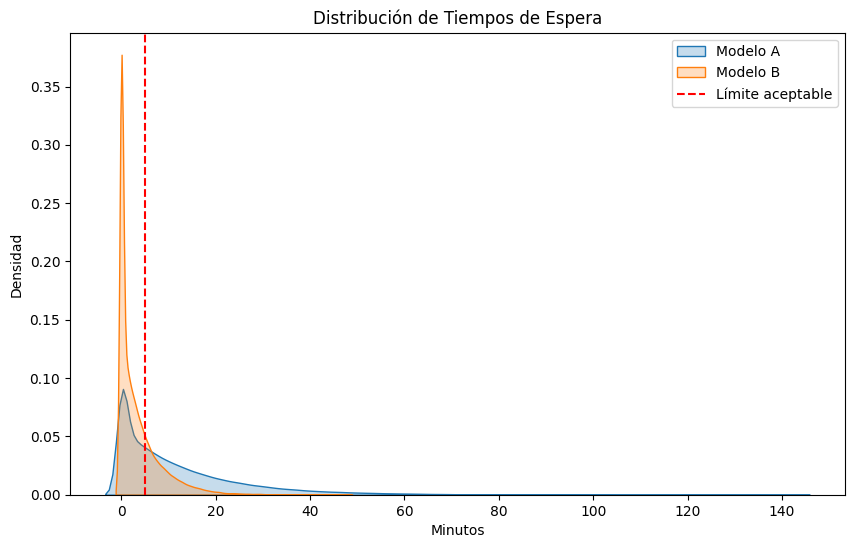

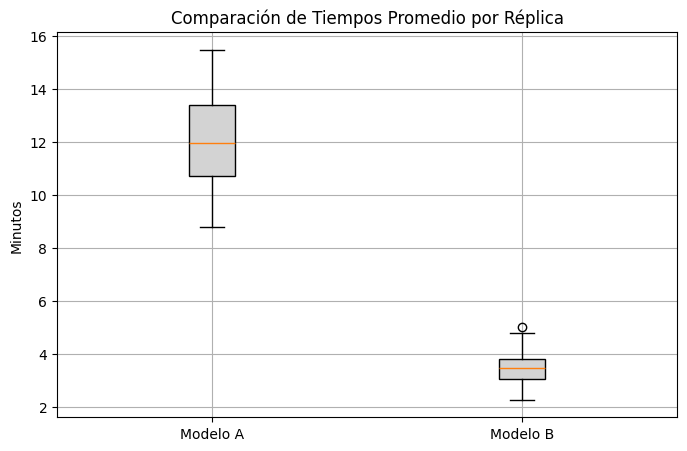

In [1]:
import simpy
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def simular_panis(lambda_, mu, sim_time=10000, num_servers=3, warmup=1000):
    """Simula ambos modelos de colas y retorna tiempos de espera y clientes atendidos"""
    def run_simulacion(env, modelo):
        if modelo == 'A':
            servidores = [simpy.Resource(env, capacity=1) for _ in range(num_servers)]
            wait_times = []
            clientes_atendidos = 0
            
            def cliente(env):
                nonlocal clientes_atendidos
                llegada = env.now
                server_id = random.randint(0, num_servers - 1)
                with servidores[server_id].request() as req:
                    yield req
                    espera = env.now - llegada
                    if env.now > warmup:
                        wait_times.append(espera)
                        clientes_atendidos += 1
                    servicio = random.expovariate(mu)
                    yield env.timeout(servicio)
                    
            def generador(env):
                while True:
                    env.process(cliente(env))
                    yield env.timeout(random.expovariate(lambda_))
                    
            env.process(generador(env))
            env.run(until=sim_time + warmup)
            return wait_times, clientes_atendidos
            
        elif modelo == 'B':
            servidores = simpy.Resource(env, capacity=num_servers)
            wait_times = []
            clientes_atendidos = 0
            
            def cliente(env):
                nonlocal clientes_atendidos
                llegada = env.now
                with servidores.request() as req:
                    yield req
                    espera = env.now - llegada
                    if env.now > warmup:
                        wait_times.append(espera)
                        clientes_atendidos += 1
                    servicio = random.expovariate(mu)
                    yield env.timeout(servicio)
                    
            def generador(env):
                while True:
                    env.process(cliente(env))
                    yield env.timeout(random.expovariate(lambda_))
            
            env.process(generador(env))
            env.run(until=sim_time + warmup)
            return wait_times, clientes_atendidos

    # Simular Modelo A
    env_A = simpy.Environment()
    wait_times_A, clientes_A = run_simulacion(env_A, 'A')
    
    # Simular Modelo B
    env_B = simpy.Environment()
    wait_times_B, clientes_B = run_simulacion(env_B, 'B')
    
    return {
        'Modelo_A': {
            'datos': wait_times_A,
            'clientes_atendidos': clientes_A
        },
        'Modelo_B': {
            'datos': wait_times_B,
            'clientes_atendidos': clientes_B
        }
    }

def ejecutar_varias_simulaciones(lambda_, mu, n=30):
    """Ejecuta múltiples réplicas y calcula métricas agregadas"""
    todos_A = []
    todos_B = []
    promedios_A = []
    promedios_B = []
    clientes_A = []
    clientes_B = []

    for _ in range(n):
        resultados = simular_panis(lambda_, mu)
        
        # Datos Modelo A
        tiempos_A = resultados['Modelo_A']['datos']
        todos_A.extend(tiempos_A)
        promedios_A.append(np.mean(tiempos_A))
        clientes_A.append(resultados['Modelo_A']['clientes_atendidos'])
        
        # Datos Modelo B
        tiempos_B = resultados['Modelo_B']['datos']
        todos_B.extend(tiempos_B)
        promedios_B.append(np.mean(tiempos_B))
        clientes_B.append(resultados['Modelo_B']['clientes_atendidos'])

    def calcular_estadisticos(datos, promedios, clientes):
        return {
            'media': np.mean(promedios),
            'mediana': np.median(datos),
            'percentil_95': np.percentile(datos, 95),
            'IC_95': stats.t.interval(0.95, len(promedios)-1, 
                                    loc=np.mean(promedios), 
                                    scale=stats.sem(promedios)),
            'datos': datos,
            'promedios': promedios,
            'clientes_atendidos': clientes
        }

    return {
        'Modelo_A': calcular_estadisticos(todos_A, promedios_A, clientes_A),
        'Modelo_B': calcular_estadisticos(todos_B, promedios_B, clientes_B)
    }

def visualizar_resultados(resultados):
    """Genera gráficos comparativos"""
    # Gráfico de densidad
    plt.figure(figsize=(10, 6))
    sns.kdeplot(resultados['Modelo_A']['datos'], label='Modelo A', fill=True)
    sns.kdeplot(resultados['Modelo_B']['datos'], label='Modelo B', fill=True)
    plt.title('Distribución de Tiempos de Espera')
    plt.xlabel('Minutos')
    plt.ylabel('Densidad')
    plt.axvline(5, color='red', linestyle='--', label='Límite aceptable')
    plt.legend()
    plt.show()
    
    # Gráfico de caja
    plt.figure(figsize=(8, 5))
    plt.boxplot([resultados['Modelo_A']['promedios'], 
                resultados['Modelo_B']['promedios']],
                labels=['Modelo A', 'Modelo B'],
                patch_artist=True,
                boxprops={'facecolor': 'lightgray'})
    plt.title('Comparación de Tiempos Promedio por Réplica')
    plt.ylabel('Minutos')
    plt.grid(True)
    plt.show()

def mostrar_estadisticos(resultados):
    """Muestra resultados numéricos en consola"""
    print("=== Análisis Estadístico Completo ===")
    for modelo in ['Modelo_A', 'Modelo_B']:
        stats = resultados[modelo]
        print(f"\n{modelo}:")
        print(f"  - Media: {stats['media']:.2f} min")
        print(f"  - Mediana: {stats['mediana']:.2f} min")
        print(f"  - Percentil 95%: {stats['percentil_95']:.2f} min")
        print(f"  - IC 95% media: [{stats['IC_95'][0]:.2f}, {stats['IC_95'][1]:.2f}] min")
        print(f"  - Clientes atendidos promedio: {np.mean(stats['clientes_atendidos']):.0f}")
        print(f"  - Observaciones totales: {len(stats['datos'])}")

if __name__ == "__main__":
    # Configuración base
    config = {
        'lambda': 1.0,  # clientes/minuto
        'mu': 0.4,      # clientes/minuto
        'n': 30         # réplicas
    }
    
    # Ejecutar simulaciones
    resultados = ejecutar_varias_simulaciones(config['lambda'], config['mu'], config['n'])
    
    # Mostrar resultados
    mostrar_estadisticos(resultados)
    visualizar_resultados(resultados)

# Variación de parámetros

=== Experimento 1: Variación de λ ===
λ=0.10 | A: 0.23 min | B: 0.00 min
λ=0.20 | A: 0.48 min | B: 0.02 min
λ=0.30 | A: 0.82 min | B: 0.05 min
λ=0.40 | A: 1.27 min | B: 0.12 min
λ=0.50 | A: 1.79 min | B: 0.22 min
λ=0.60 | A: 2.46 min | B: 0.40 min
λ=0.70 | A: 3.61 min | B: 0.70 min
λ=0.80 | A: 5.05 min | B: 1.04 min
λ=0.90 | A: 7.61 min | B: 1.86 min
λ=1.00 | A: 12.93 min | B: 3.65 min


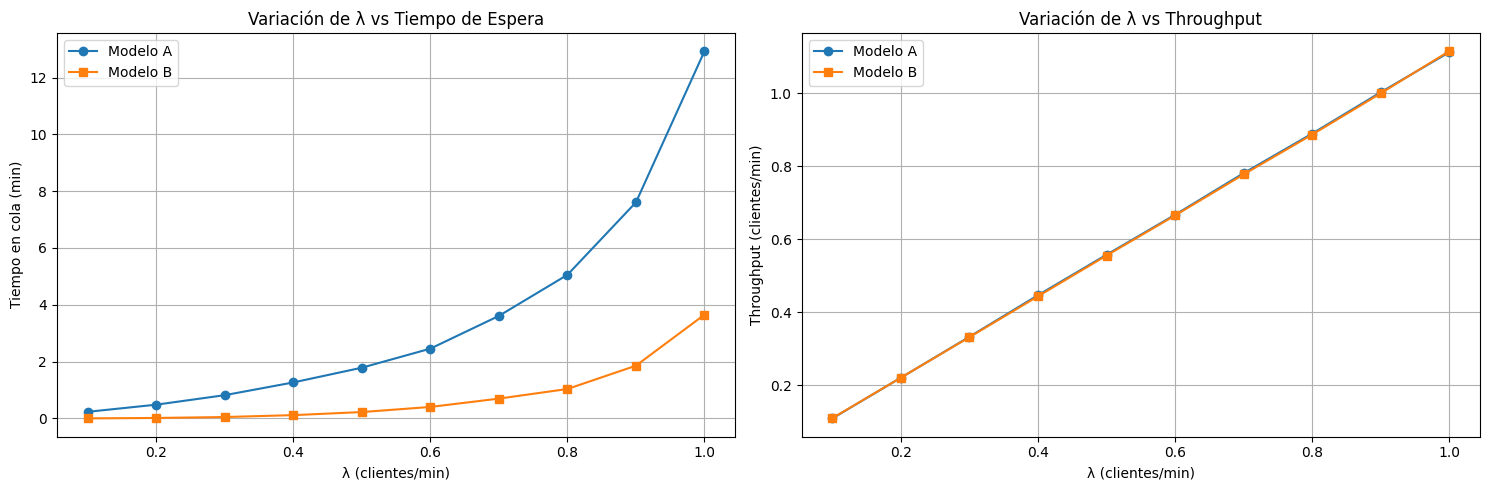


=== Experimento 2: Variación de μ ===
μ=0.30 | A: 622.51 min | B: 610.09 min
μ=0.32 | A: 271.70 min | B: 262.20 min
μ=0.34 | A: 98.80 min | B: 39.52 min
μ=0.36 | A: 30.10 min | B: 10.83 min
μ=0.38 | A: 18.02 min | B: 5.54 min
μ=0.40 | A: 12.31 min | B: 3.54 min
μ=0.42 | A: 9.12 min | B: 2.46 min
μ=0.44 | A: 7.09 min | B: 1.69 min
μ=0.46 | A: 5.75 min | B: 1.40 min
μ=0.48 | A: 4.75 min | B: 1.10 min
μ=0.50 | A: 3.97 min | B: 0.86 min


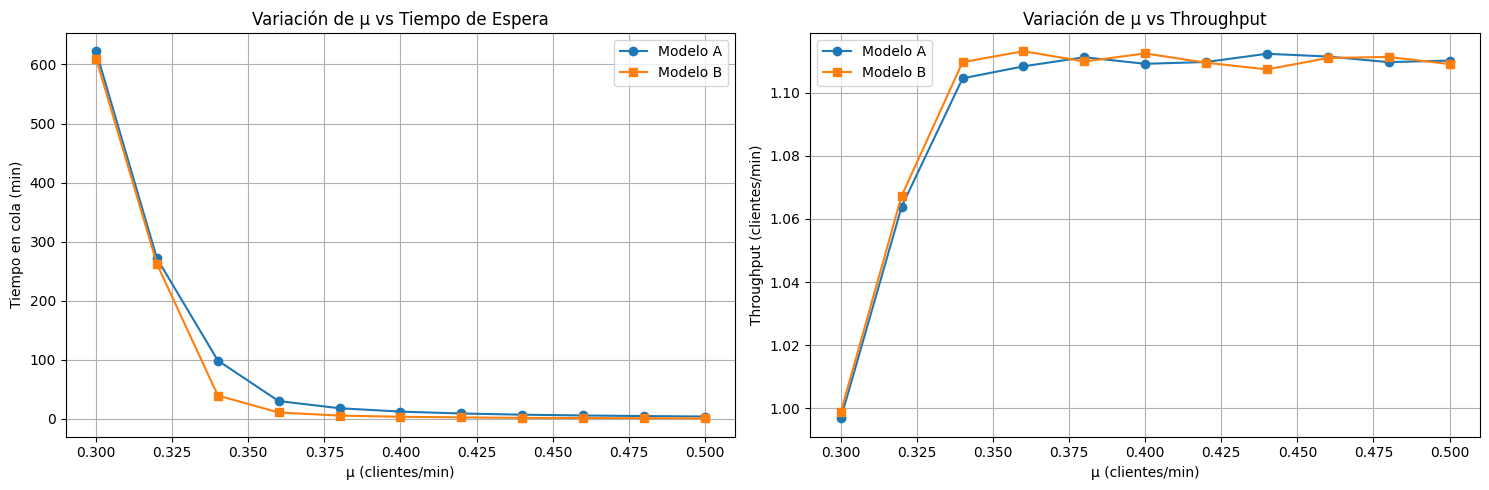

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# from simulacion import ejecutar_varias_simulaciones

def experimento_variar_lambda():
    # Configuración
    lambdas = np.linspace(0.1, 1.0, 10)
    mu_fijo = 0.4
    sim_time = 10000
    warmup = 1000
    tiempo_efectivo = sim_time - warmup
    
    resultados_A = {'Wq': [], 'throughput': []}
    resultados_B = {'Wq': [], 'throughput': []}

    for lambda_ in lambdas:
        resultados = ejecutar_varias_simulaciones(lambda_, mu_fijo, n=30)
        
        # Modelo A
        wq_A = resultados['Modelo_A']['media']
        throughput_A = np.mean(resultados['Modelo_A']['clientes_atendidos']) / tiempo_efectivo
        resultados_A['Wq'].append(wq_A)
        resultados_A['throughput'].append(throughput_A)
        
        # Modelo B
        wq_B = resultados['Modelo_B']['media']
        throughput_B = np.mean(resultados['Modelo_B']['clientes_atendidos']) / tiempo_efectivo
        resultados_B['Wq'].append(wq_B)
        resultados_B['throughput'].append(throughput_B)
        
        print(f"λ={lambda_:.2f} | A: {wq_A:.2f} min | B: {wq_B:.2f} min")

    # Gráficos
    plt.figure(figsize=(15, 5))
    
    # Tiempo de espera
    plt.subplot(1, 2, 1)
    plt.plot(lambdas, resultados_A['Wq'], 'o-', label='Modelo A')
    plt.plot(lambdas, resultados_B['Wq'], 's-', label='Modelo B')
    plt.xlabel('λ (clientes/min)')
    plt.ylabel('Tiempo en cola (min)')
    plt.title('Variación de λ vs Tiempo de Espera')
    plt.grid(True)
    plt.legend()

    # Throughput
    plt.subplot(1, 2, 2)
    plt.plot(lambdas, resultados_A['throughput'], 'o-', label='Modelo A')
    plt.plot(lambdas, resultados_B['throughput'], 's-', label='Modelo B')
    plt.xlabel('λ (clientes/min)')
    plt.ylabel('Throughput (clientes/min)')
    plt.title('Variación de λ vs Throughput')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def experimento_variar_mu():
    # Configuración
    mus = np.linspace(0.3, 0.5, 11)
    lambda_fijo = 1.0
    sim_time = 10000
    warmup = 1000
    tiempo_efectivo = sim_time - warmup
    
    resultados_A = {'Wq': [], 'throughput': []}
    resultados_B = {'Wq': [], 'throughput': []}

    for mu in mus:
        resultados = ejecutar_varias_simulaciones(lambda_fijo, mu, n=30)
        
        # Modelo A
        wq_A = resultados['Modelo_A']['media']
        throughput_A = np.mean(resultados['Modelo_A']['clientes_atendidos']) / tiempo_efectivo
        resultados_A['Wq'].append(wq_A)
        resultados_A['throughput'].append(throughput_A)
        
        # Modelo B
        wq_B = resultados['Modelo_B']['media']
        throughput_B = np.mean(resultados['Modelo_B']['clientes_atendidos']) / tiempo_efectivo
        resultados_B['Wq'].append(wq_B)
        resultados_B['throughput'].append(throughput_B)
        
        print(f"μ={mu:.2f} | A: {wq_A:.2f} min | B: {wq_B:.2f} min")

    # Gráficos
    plt.figure(figsize=(15, 5))
    
    # Tiempo de espera
    plt.subplot(1, 2, 1)
    plt.plot(mus, resultados_A['Wq'], 'o-', label='Modelo A')
    plt.plot(mus, resultados_B['Wq'], 's-', label='Modelo B')
    plt.xlabel('μ (clientes/min)')
    plt.ylabel('Tiempo en cola (min)')
    plt.title('Variación de μ vs Tiempo de Espera')
    plt.grid(True)
    plt.legend()

    # Throughput
    plt.subplot(1, 2, 2)
    plt.plot(mus, resultados_A['throughput'], 'o-', label='Modelo A')
    plt.plot(mus, resultados_B['throughput'], 's-', label='Modelo B')
    plt.xlabel('μ (clientes/min)')
    plt.ylabel('Throughput (clientes/min)')
    plt.title('Variación de μ vs Throughput')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("=== Experimento 1: Variación de λ ===")
    experimento_variar_lambda()
    
    print("\n=== Experimento 2: Variación de μ ===")
    experimento_variar_mu()

# Distribución de tiempos de espera 

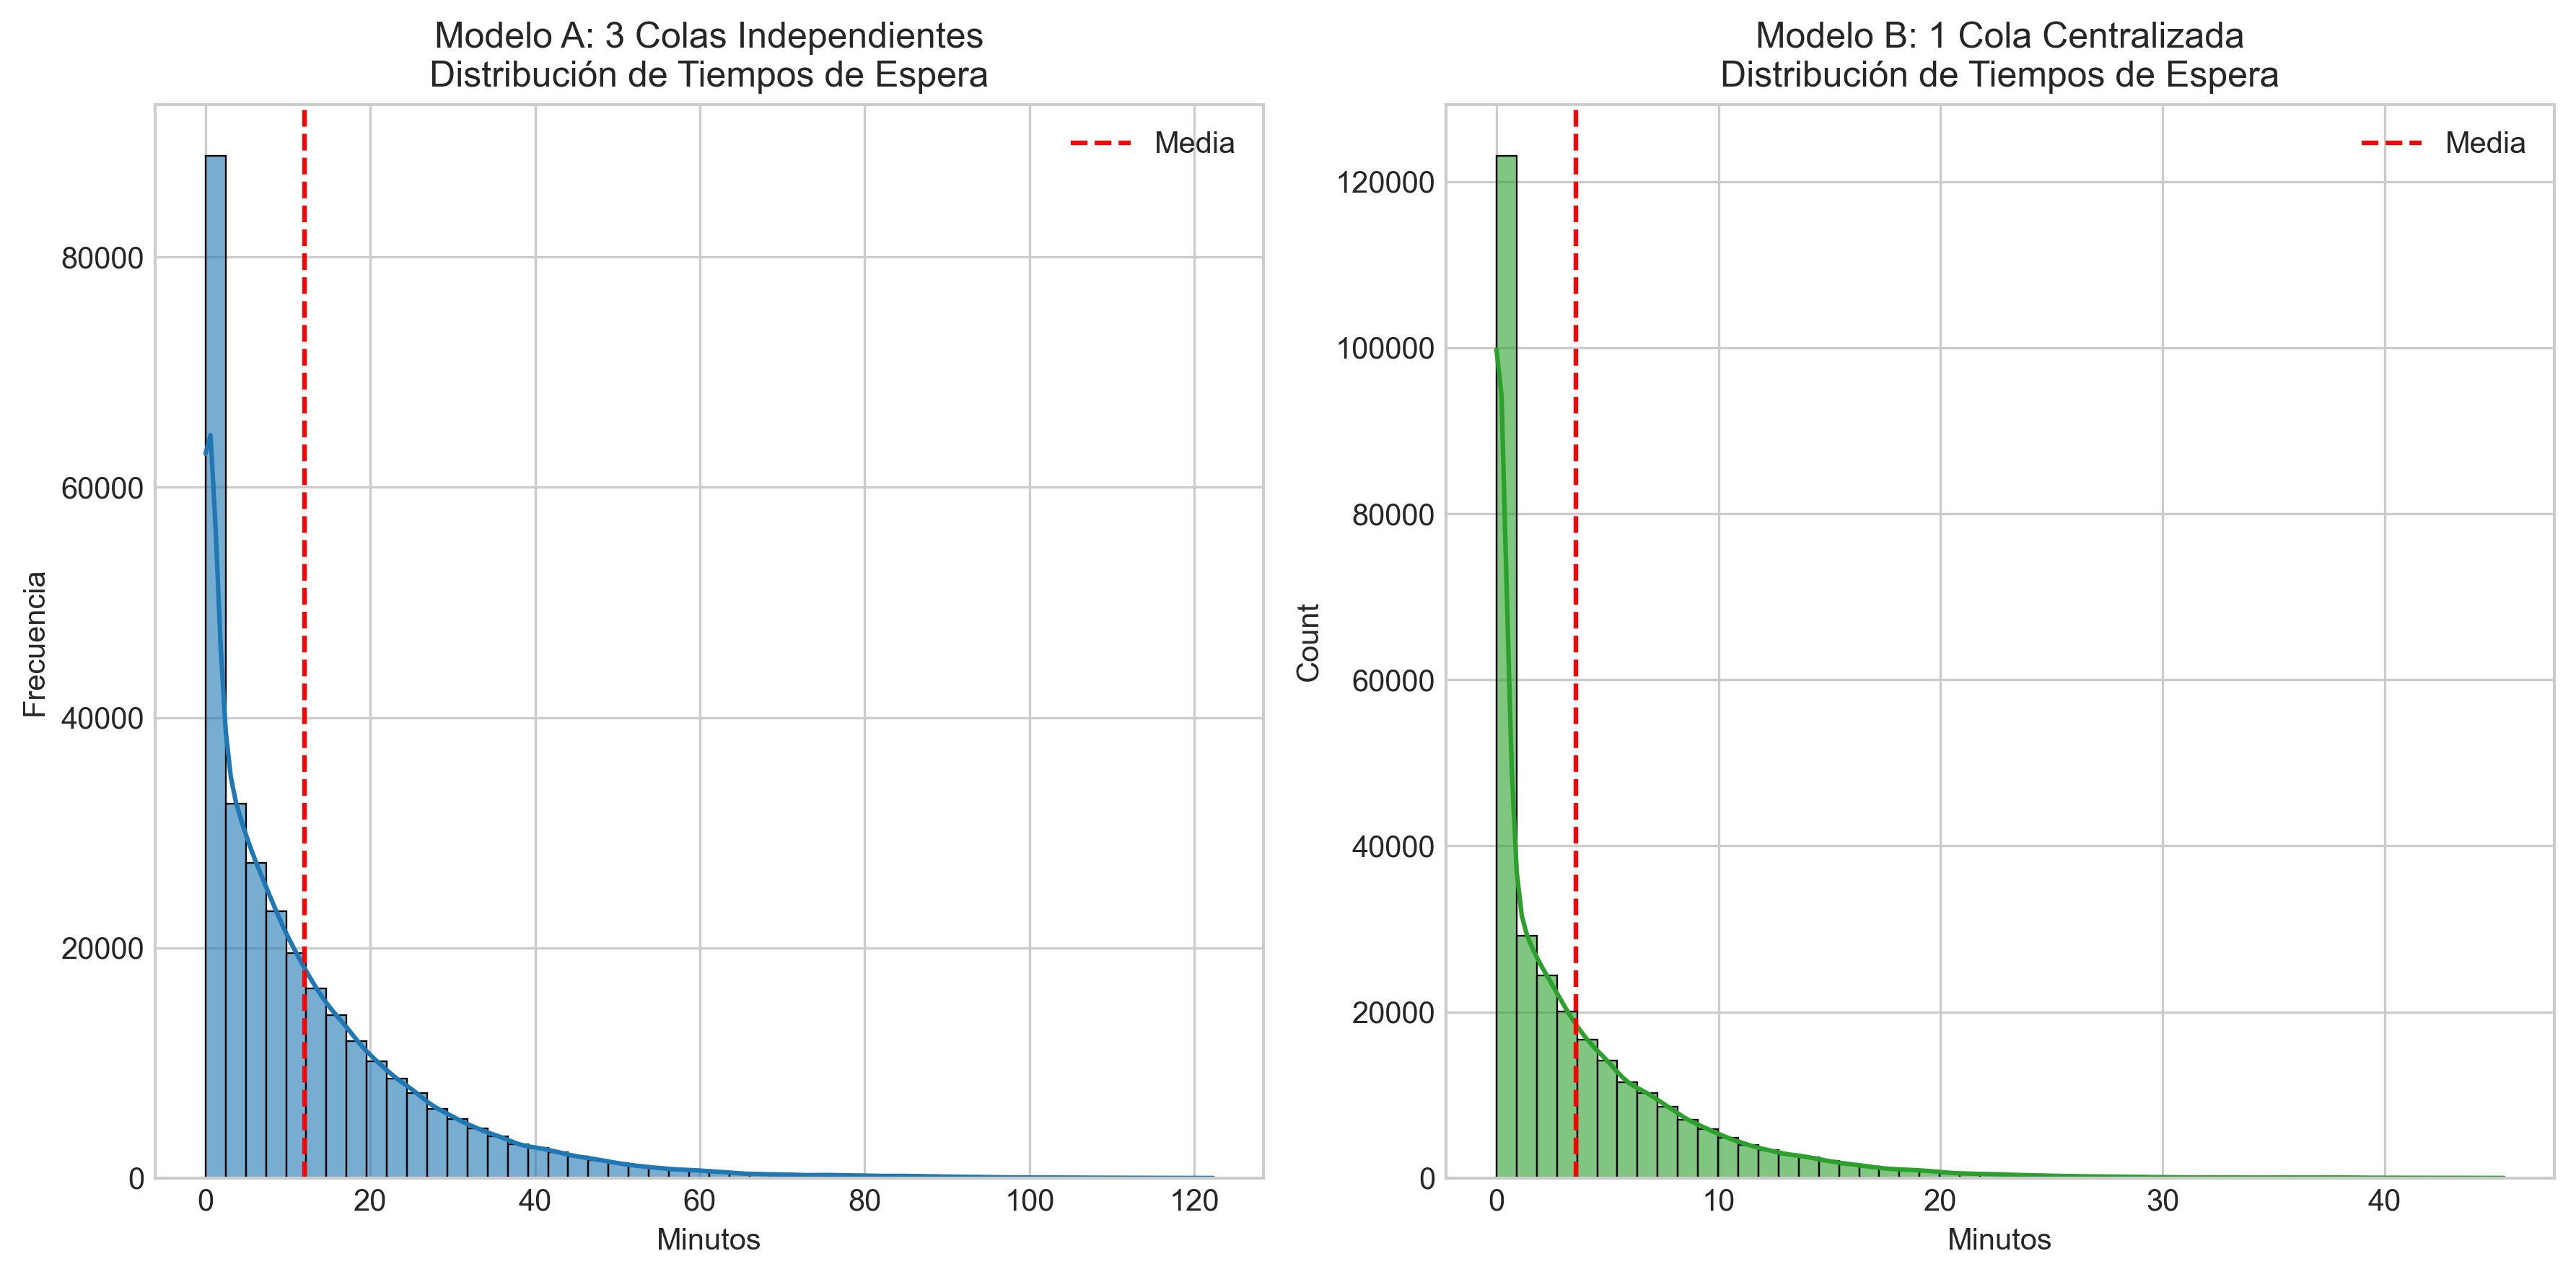

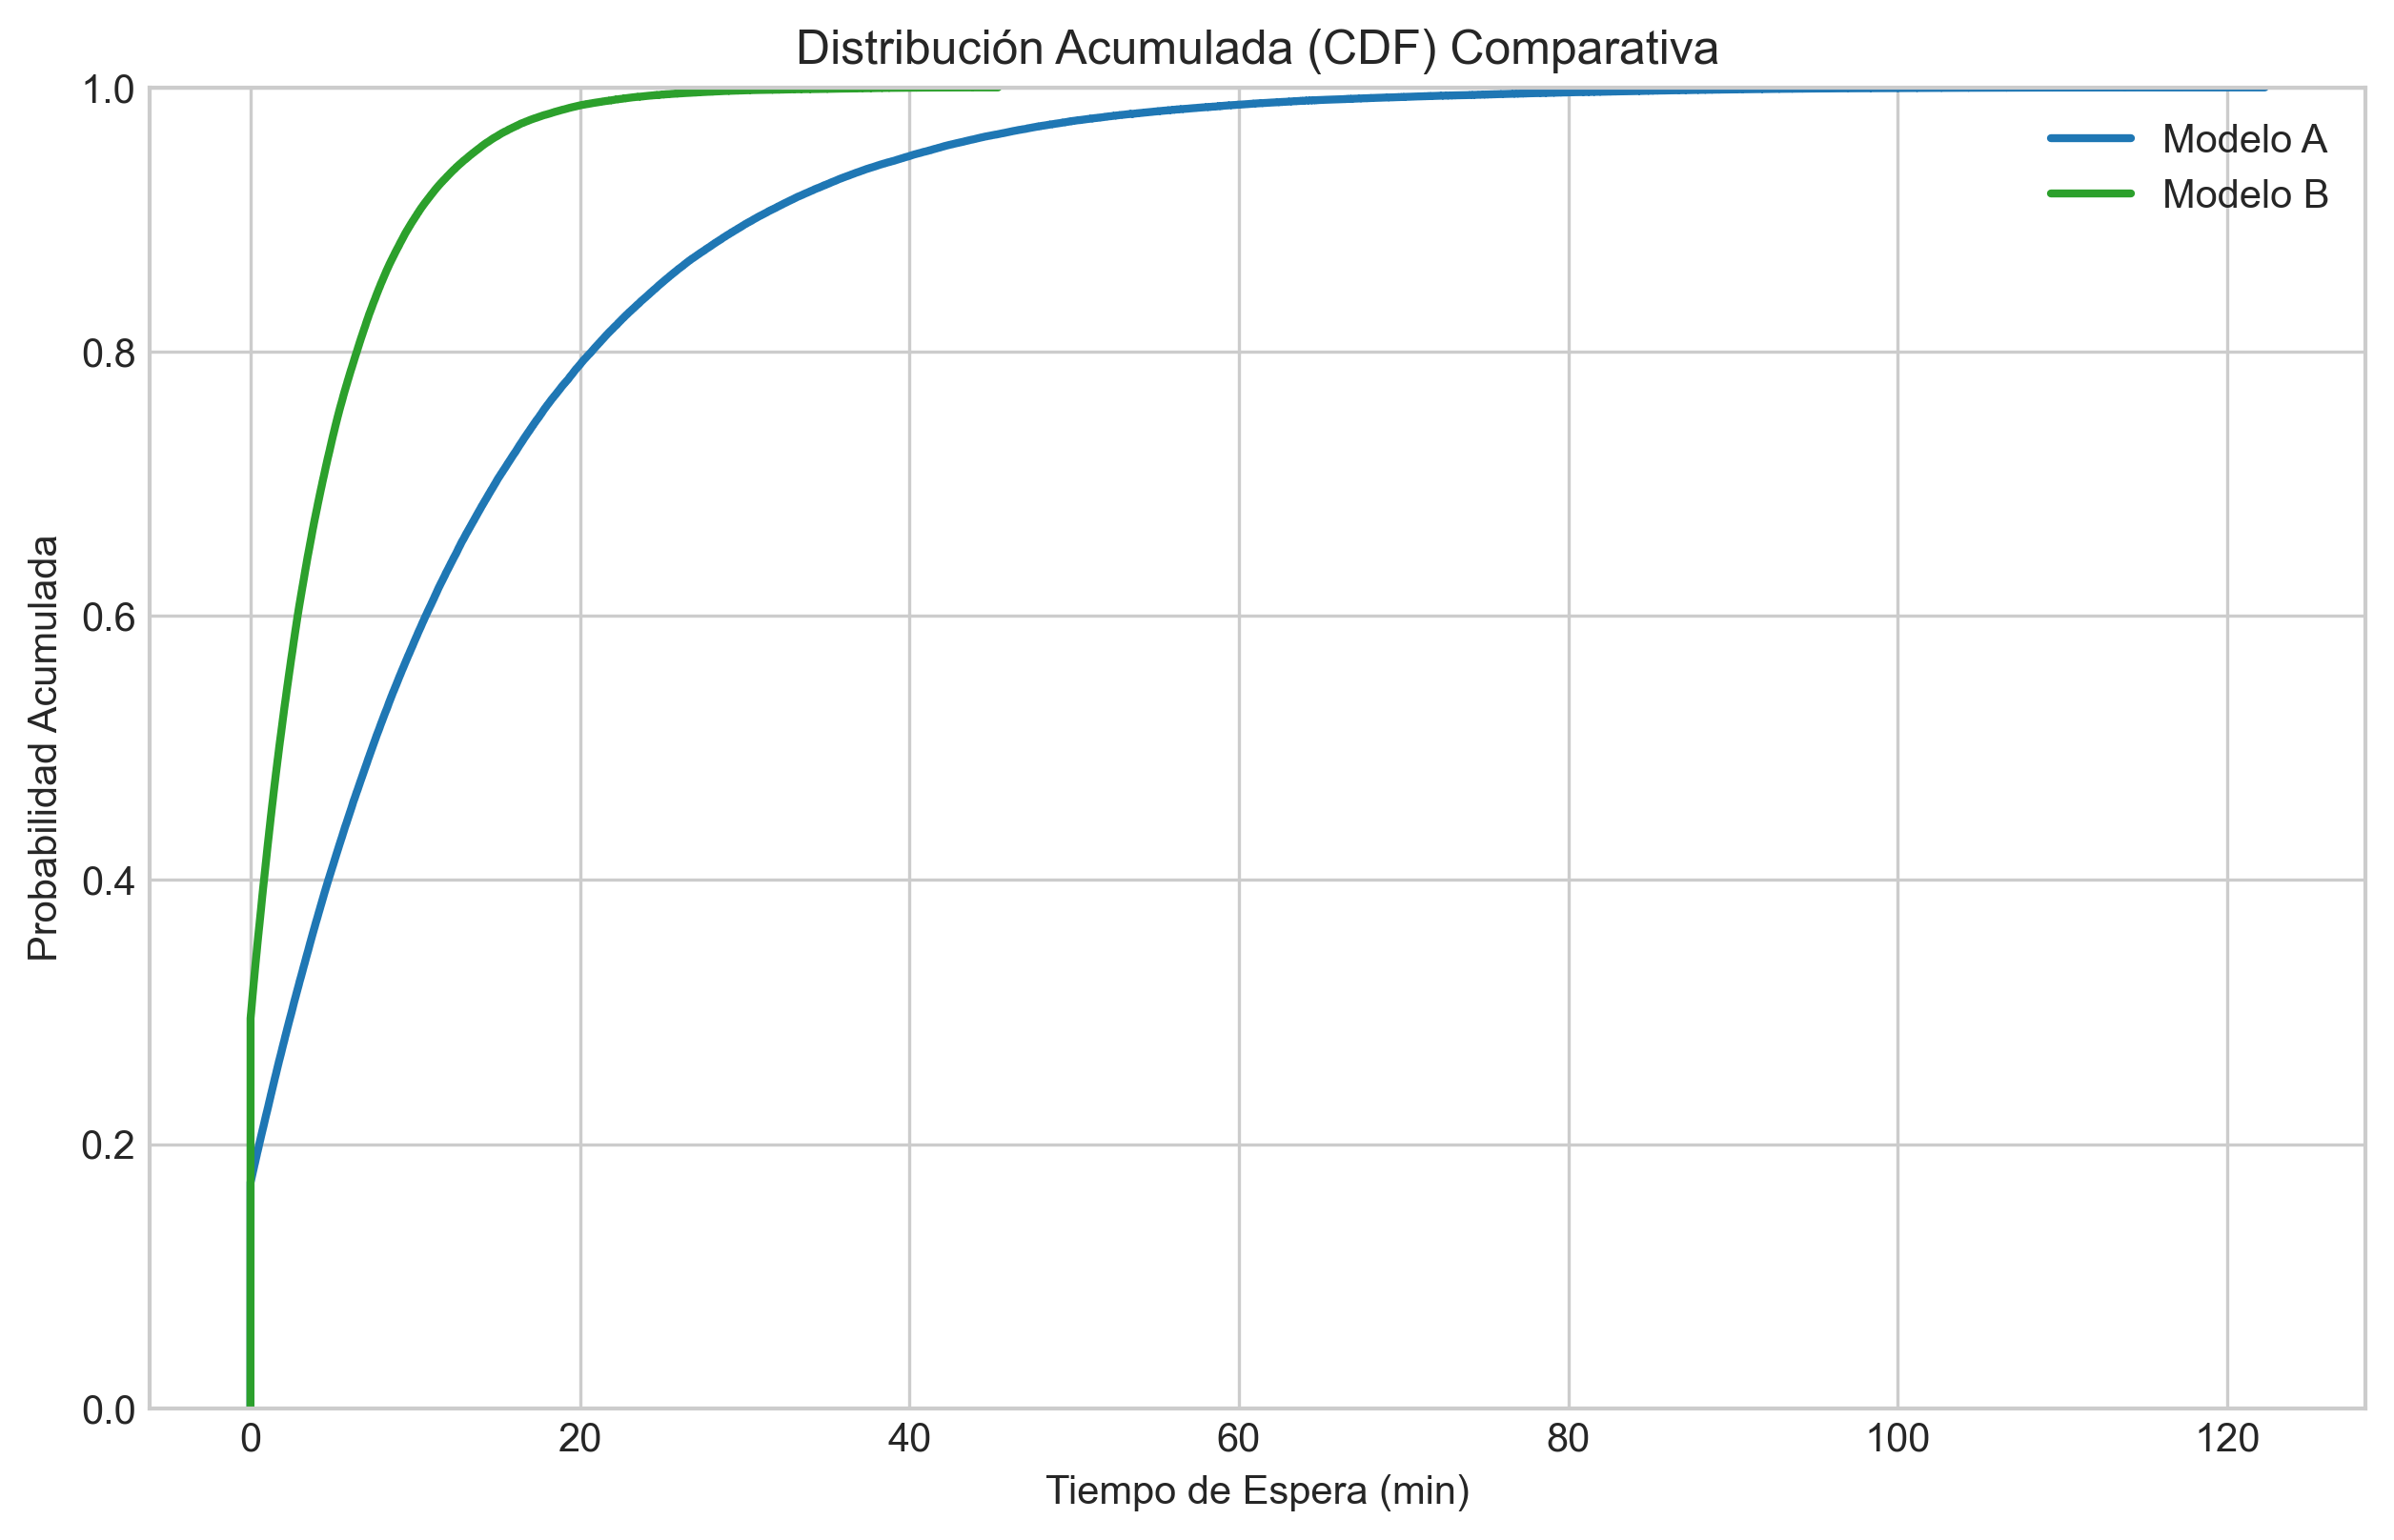


=== Resultados del Análisis de Distribuciones ===

Pruebas de Bondad de Ajuste:
Modelo A (Exponencial) - KS Stat: 0.1707, p-value: 0.0000
Modelo B (Erlang k=1) - KS Stat: 0.2942, p-value: 0.0000

Métricas de Forma:

Modelo A:
- Asimetría: 2.01
- Curtosis: 5.46
- Diferencia Media-Mediana: 4.64 min
- Coef. Variación: 1.18

Modelo B:
- Asimetría: 2.25
- Curtosis: 7.08
- Diferencia Media-Mediana: 1.85 min
- Coef. Variación: 1.36


In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#from simulacion import ejecutar_varias_simulaciones

def analizar_distribuciones(resultados):
    """Analiza y visualiza las distribuciones de tiempos de espera"""
    # Extraer datos de ambos modelos
    datos_A = resultados['Modelo_A']['datos']
    datos_B = resultados['Modelo_B']['datos']
    
    # Añadir pequeño épsilon para evitar valores cero
    datos_B = np.array(datos_B) + 1e-6
    
    # ======================================
    # 1. Visualizaciones
    # ======================================
    
    # Configuración común para gráficos
    plt.rcParams['figure.dpi'] = 300
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # a. Histogramas comparativos
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(datos_A, kde=True, color='#1f77b4', bins=50, alpha=0.6)
    plt.title('Modelo A: 3 Colas Independientes\nDistribución de Tiempos de Espera')
    plt.xlabel('Minutos')
    plt.ylabel('Frecuencia')
    plt.axvline(np.mean(datos_A), color='red', linestyle='--', label='Media')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.histplot(datos_B, kde=True, color='#2ca02c', bins=50, alpha=0.6)
    plt.title('Modelo B: 1 Cola Centralizada\nDistribución de Tiempos de Espera')
    plt.xlabel('Minutos')
    plt.axvline(np.mean(datos_B), color='red', linestyle='--', label='Media')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # b. Gráfico CDF comparativo
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(datos_A, label='Modelo A', color='#1f77b4', linewidth=2)
    sns.ecdfplot(datos_B, label='Modelo B', color='#2ca02c', linewidth=2)
    plt.title('Distribución Acumulada (CDF) Comparativa')
    plt.xlabel('Tiempo de Espera (min)')
    plt.ylabel('Probabilidad Acumulada')
    plt.legend()
    plt.show()
    
    # ======================================
    # 2. Pruebas de Bondad de Ajuste (CORREGIDO)
    # ======================================
    
    # a. Para Modelo A (Exponencial)
    lambda_estimado_A = 1 / np.mean(datos_A)
    ks_A = stats.kstest(datos_A, 'expon', args=(0, 1/lambda_estimado_A))
    
    # b. Para Modelo B (Erlang - método de momentos)
    # Calcular parámetros usando método de momentos
    mean_B = np.mean(datos_B)
    var_B = np.var(datos_B, ddof=1)
    k_est = int(round((mean_B**2) / var_B))  # k debe ser entero
    mu_est = k_est / mean_B
    
    # Asegurar parámetros válidos
    k_est = max(1, k_est)  # Mínimo k=1
    mu_est = max(0.1, mu_est)  # Evitar valores cero
    
    # Realizar prueba KS
    ks_B = stats.kstest(datos_B, stats.erlang.cdf, args=(k_est, 0, 1/mu_est))
    
    # ======================================
    # 3. Métricas de Forma
    # ======================================
    
    def calcular_metricas(datos, nombre):
        return {
            'Modelo': nombre,
            'Asimetría (Skewness)': stats.skew(datos),
            'Curtosis': stats.kurtosis(datos),
            'Media-Mediana': np.mean(datos) - np.median(datos),
            'CV (Coef. Variación)': np.std(datos)/np.mean(datos)
        }
    
    metricas_A = calcular_metricas(datos_A, "Modelo A")
    metricas_B = calcular_metricas(datos_B, "Modelo B")
    
    # ======================================
    # 4. Presentación de Resultados
    # ======================================
    
    print("\n=== Resultados del Análisis de Distribuciones ===")
    
    print("\nPruebas de Bondad de Ajuste:")
    print(f"Modelo A (Exponencial) - KS Stat: {ks_A.statistic:.4f}, p-value: {ks_A.pvalue:.4f}")
    print(f"Modelo B (Erlang k={k_est}) - KS Stat: {ks_B.statistic:.4f}, p-value: {ks_B.pvalue:.4f}")
    
    print("\nMétricas de Forma:")
    print(f"\nModelo A:")
    print(f"- Asimetría: {metricas_A['Asimetría (Skewness)']:.2f}")
    print(f"- Curtosis: {metricas_A['Curtosis']:.2f}")
    print(f"- Diferencia Media-Mediana: {metricas_A['Media-Mediana']:.2f} min")
    print(f"- Coef. Variación: {metricas_A['CV (Coef. Variación)']:.2f}")
    
    print(f"\nModelo B:")
    print(f"- Asimetría: {metricas_B['Asimetría (Skewness)']:.2f}")
    print(f"- Curtosis: {metricas_B['Curtosis']:.2f}")
    print(f"- Diferencia Media-Mediana: {metricas_B['Media-Mediana']:.2f} min")
    print(f"- Coef. Variación: {metricas_B['CV (Coef. Variación)']:.2f}")

if __name__ == "__main__":
    # Configurar parámetros
    lambda_ = 1.0
    mu = 0.4
    n_replicas = 30
    
    # Obtener resultados
    resultados = ejecutar_varias_simulaciones(lambda_, mu, n_replicas)
    
    # Analizar distribuciones
    analizar_distribuciones(resultados)

# Prueba de hipótesis

In [6]:
import numpy as np
from scipy import stats
# from simulacion import ejecutar_varias_simulaciones

def realizar_prueba_hipotesis():
    # Configuración
    config = {
        'lambda': 1.0,
        'mu': 0.4,
        'n': 30
    }
    
    # Ejecutar simulaciones
    resultados = ejecutar_varias_simulaciones(config['lambda'], config['mu'], config['n'])
    
    # Extraer datos
    medias_A = resultados['Modelo_A']['promedios']
    medias_B = resultados['Modelo_B']['promedios']
    
    # 1. Verificar normalidad
    normalidad_A = stats.shapiro(medias_A)
    normalidad_B = stats.shapiro(medias_B)
    
    # 2. Inicializar variables
    prueba_usada = ""
    estadistico = None
    p_val = None
    
    # 3. Seleccionar prueba
    if normalidad_A.pvalue > 0.05 and normalidad_B.pvalue > 0.05:
        # Prueba paramétrica
        t_stat, p_val = stats.ttest_ind(medias_A, medias_B, alternative='greater')
        prueba_usada = "t-test"
        estadistico = t_stat
    else:
        # Prueba no paramétrica
        U_stat, p_val = stats.mannwhitneyu(medias_A, medias_B, alternative='greater')
        prueba_usada = "Mann-Whitney U"
        estadistico = U_stat
    
    # 4. Calcular tamaño del efecto
    pooled_std = np.sqrt((np.std(medias_A, ddof=1)**2 + np.std(medias_B, ddof=1)**2) / 2)
    cohen_d = (np.mean(medias_A) - np.mean(medias_B)) / pooled_std
    
    # 5. Resultados
    print("\n" + "="*50)
    print(" PRUEBA DE HIPÓTESIS ".center(50, '='))
    print("="*50)
    
    print(f"\nConfiguración:")
    print(f"- Réplicas: {config['n']}")
    print(f"- Lambda: {config['lambda']} clientes/min")
    print(f"- Mu: {config['mu']} clientes/min")
    
    print("\nSupuestos:")
    print(f"- Normalidad Modelo A (Shapiro-Wilk): p = {normalidad_A.pvalue:.4f}")
    print(f"- Normalidad Modelo B (Shapiro-Wilk): p = {normalidad_B.pvalue:.4f}")
    print(f"- Prueba usada: {prueba_usada}")
    
    print("\nResultados:")
    print(f"- Estadístico = {estadistico:.2f}")
    print(f"- Valor p = {p_val:.6f}")
    print(f"- Tamaño efecto (Cohen's d) = {cohen_d:.2f}")
    
    print("\nInterpretación:")
    if p_val < 0.05:
        print("Rechazo H0: El Modelo B tiene tiempos de espera significativamente menores (p < 0.05).")
    else:
        print("No se rechaza H0: No hay diferencia significativa entre modelos.")
    
    print("\n" + "="*50)

if __name__ == "__main__":
    realizar_prueba_hipotesis()


============== PRUEBA DE HIPÓTESIS ===============

Configuración:
- Réplicas: 30
- Lambda: 1.0 clientes/min
- Mu: 0.4 clientes/min

Supuestos:
- Normalidad Modelo A (Shapiro-Wilk): p = 0.0405
- Normalidad Modelo B (Shapiro-Wilk): p = 0.1506
- Prueba usada: Mann-Whitney U

Resultados:
- Estadístico = 900.00
- Valor p = 0.000000
- Tamaño efecto (Cohen's d) = 9.45

Interpretación:
Rechazo H0: El Modelo B tiene tiempos de espera significativamente menores (p < 0.05).



# Test de independencia de tiempo de espera de clientes consecutivos

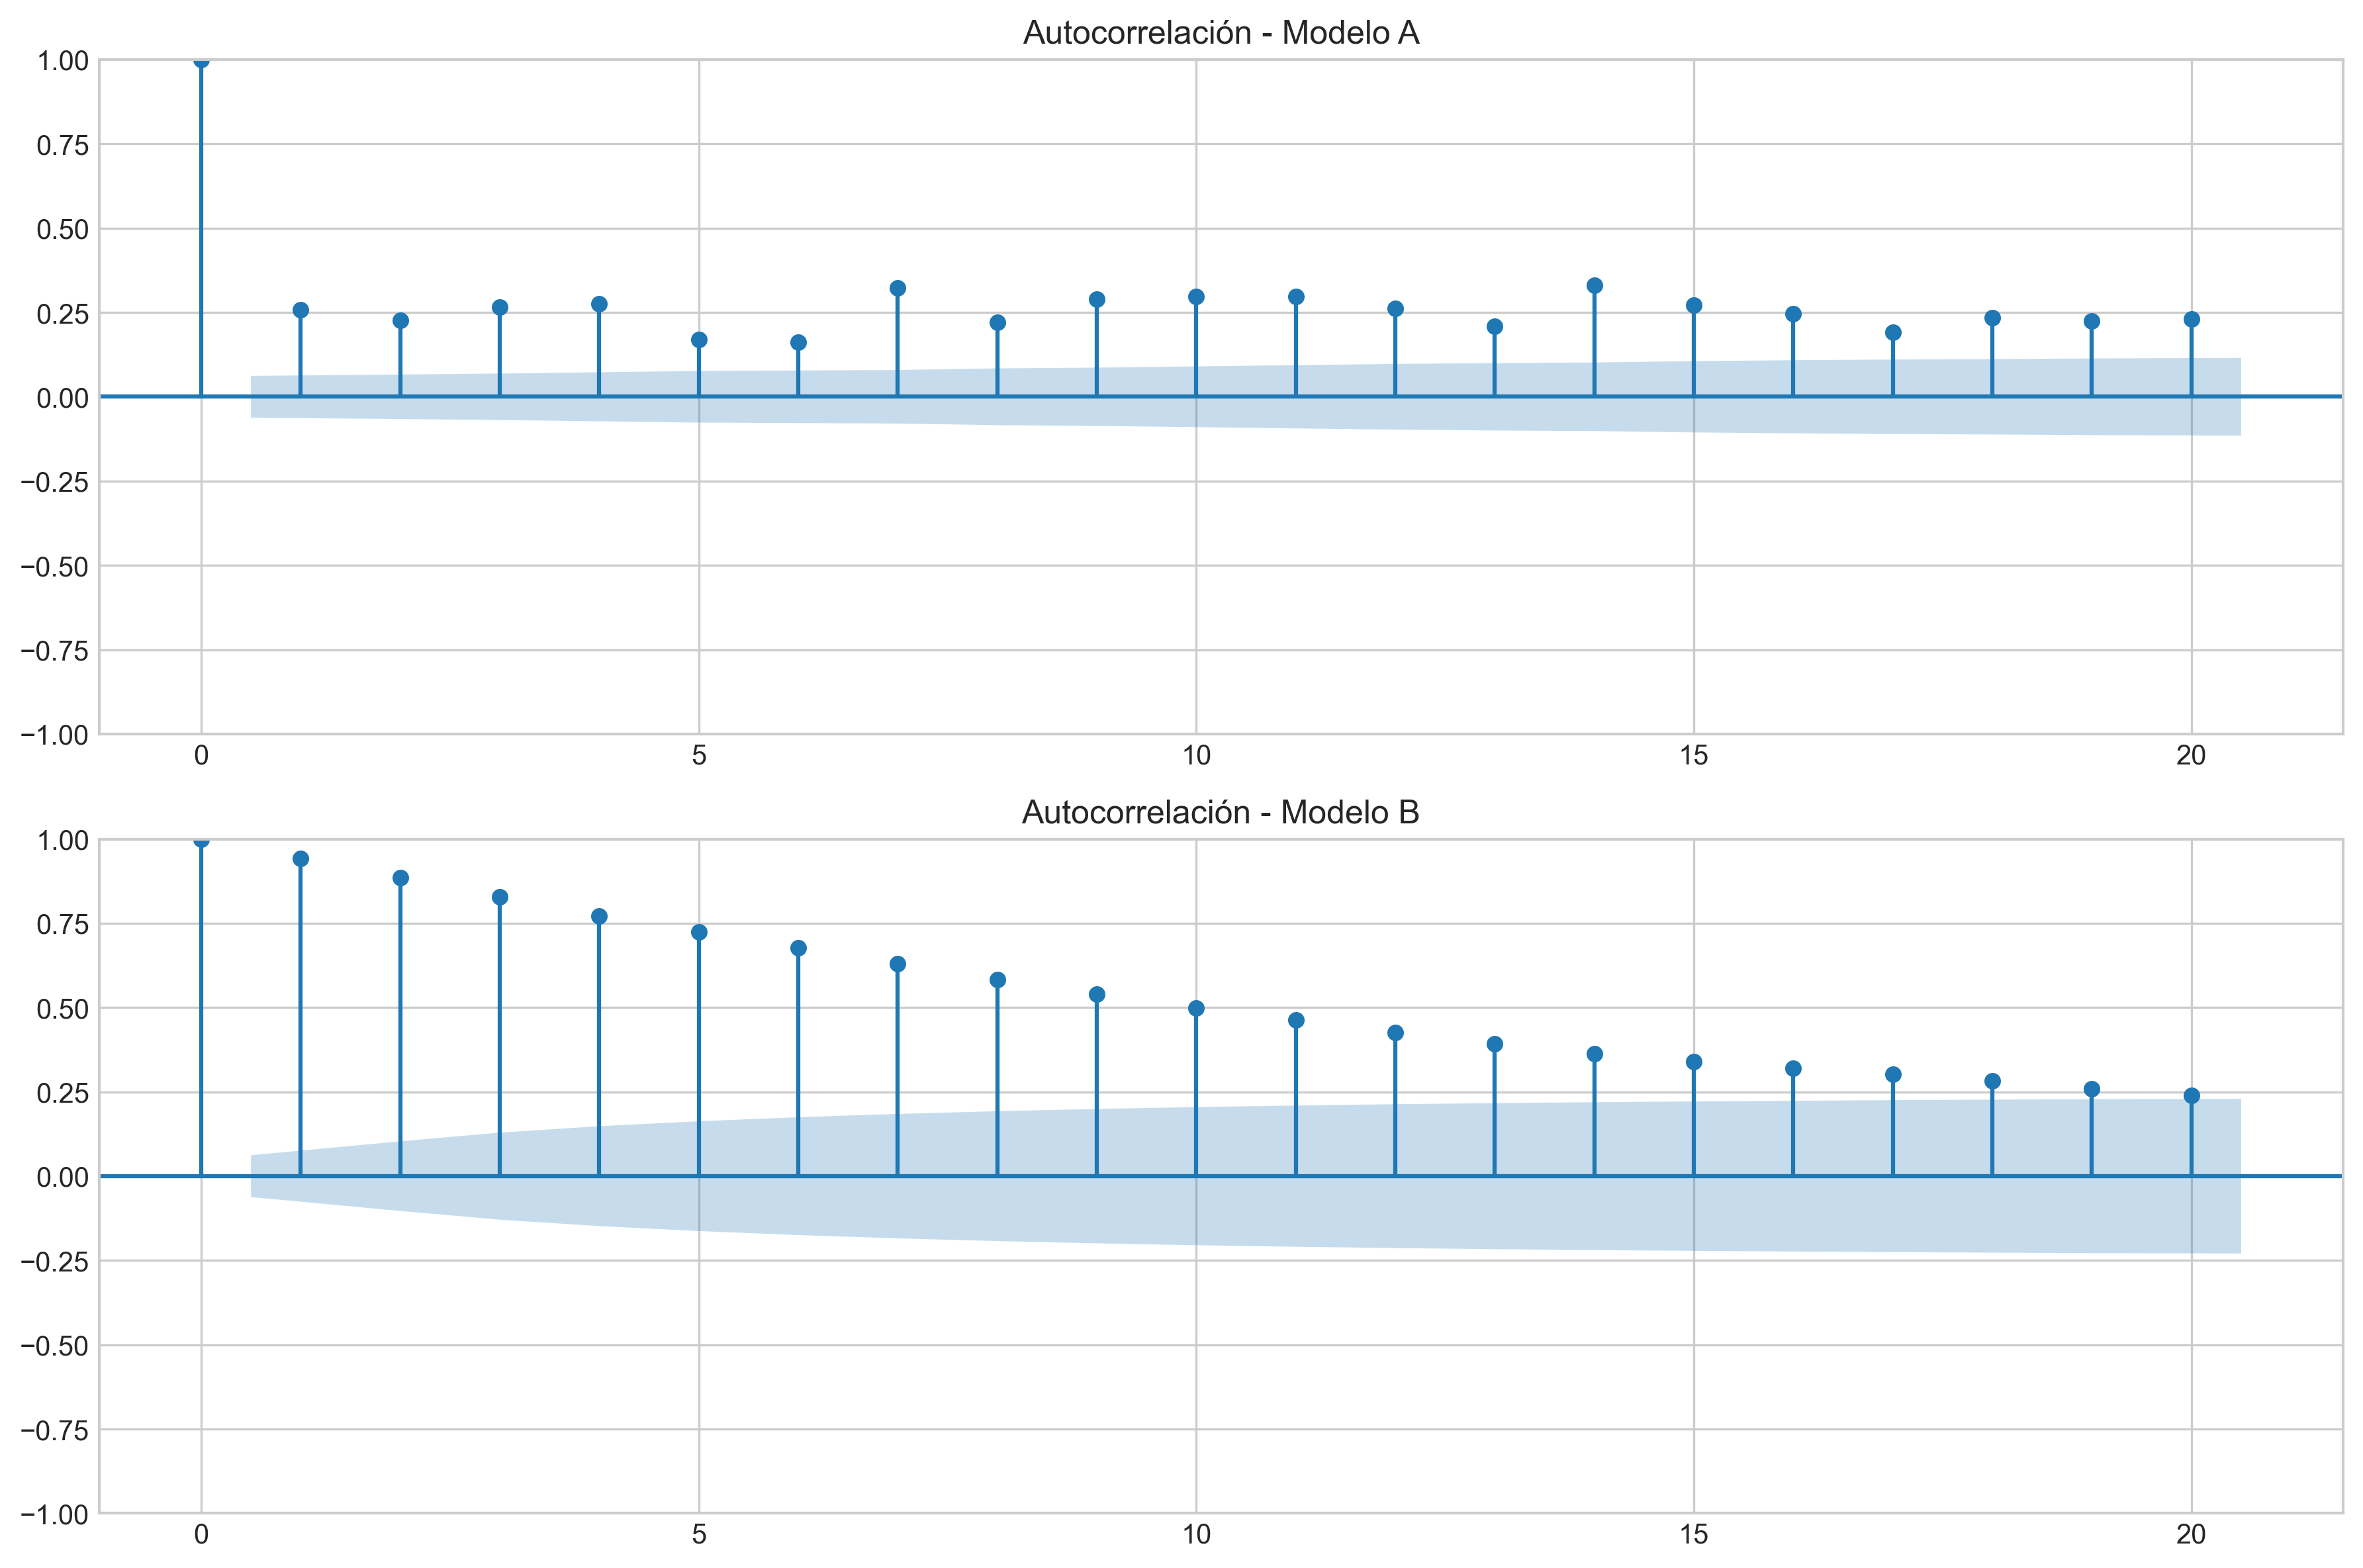


============ PRUEBA DE INDEPENDENCIA =============

Modelo A (3 colas):
- Estadístico Ljung-Box (lag 10): 649.94
- Valor-p: 0.0000

Modelo B (1 cola):
- Estadístico Ljung-Box (lag 10): 5242.38
- Valor-p: 0.0000

Interpretación (α=0.05):
- Modelo A: Se rechaza H0 → Existe autocorrelación.
- Modelo B: Se rechaza H0 → Existe autocorrelación.



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
# from simulacion import ejecutar_varias_simulaciones

def test_independencia():
    # Configuración idéntica a simulaciones previas
    config = {
        'lambda': 1.0,
        'mu': 0.4,
        'n': 30
    }
    
    # Ejecutar simulaciones
    resultados = ejecutar_varias_simulaciones(config['lambda'], config['mu'], config['n'])
    
    # Extraer datos de una réplica representativa
    datos_A = resultados['Modelo_A']['datos'][:1000]  # Muestra de 1000 datos para eficiencia
    datos_B = resultados['Modelo_B']['datos'][:1000]
    
    # 1. Test de Ljung-Box (lags=10)
    lb_A = acorr_ljungbox(datos_A, lags=10, return_df=True)
    lb_B = acorr_ljungbox(datos_B, lags=10, return_df=True)
    
    # 2. Gráficos de Autocorrelación (ACF)
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(datos_A, lags=20, ax=ax[0], title='Autocorrelación - Modelo A')
    plot_acf(datos_B, lags=20, ax=ax[1], title='Autocorrelación - Modelo B')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Resultados
    print("\n" + "="*50)
    print(" PRUEBA DE INDEPENDENCIA ".center(50, '='))
    print("="*50)
    
    print("\nModelo A (3 colas):")
    print(f"- Estadístico Ljung-Box (lag 10): {lb_A['lb_stat'].iloc[-1]:.2f}")
    print(f"- Valor-p: {lb_A['lb_pvalue'].iloc[-1]:.4f}")
    
    print("\nModelo B (1 cola):")
    print(f"- Estadístico Ljung-Box (lag 10): {lb_B['lb_stat'].iloc[-1]:.2f}")
    print(f"- Valor-p: {lb_B['lb_pvalue'].iloc[-1]:.4f}")
    
    print("\nInterpretación (α=0.05):")
    if lb_A['lb_pvalue'].iloc[-1] < 0.05:
        print("- Modelo A: Se rechaza H0 → Existe autocorrelación.")
    else:
        print("- Modelo A: No se rechaza H0 → Los datos son independientes.")
    
    if lb_B['lb_pvalue'].iloc[-1] < 0.05:
        print("- Modelo B: Se rechaza H0 → Existe autocorrelación.")
    else:
        print("- Modelo B: No se rechaza H0 → Los datos son independientes.")
    
    print("\n" + "="*50)

if __name__ == "__main__":
    test_independencia()